In [57]:
import os
import sys

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

import medmnist
from medmnist import INFO

import importlib
import moment_kernels as mk
importlib.reload(mk)

import torch
import torch.nn as tnn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.transforms.functional import rotate

import e2cnn.nn as enn
import e2cnn.gspaces as gspaces

from torcheval.metrics.functional import multiclass_confusion_matrix
import seaborn as sns
from torchmetrics.classification import ROC
from torchvision.transforms import RandomRotation
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassAUROC

import tabulate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json

# located in /rotnet/benchmark/benchmark_models.py
from models.benchmark_models import *

## **Hyperparameters**

In [58]:
# hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
lr = 0.001
num_layers = 5

## **Dataset**

In [59]:
# NOTE: SET THESE ACCORDING TO THE DATASET AND TRAINING RUN YOU WANT TO USE (after training)
data_flag = 'organamnist'# 'bloodmnist'#"breastmnist" #"bloodmnist" #'organamnist' 'dermamnist', 'pathmnist', etc...
run = 0 # 1, etc...

download = False
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Transforms**

In [60]:
# transforms to convert from image to normalized tensor (or more if augmentation)
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5]),
])

# separate transforms for test
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

## **Splitting and Shuffling**

In [61]:
train_dataset = DataClass(split = "train", transform = train_transforms, download = download)
valid_dataset = DataClass(split = "val", transform = test_transforms, download = download)
test_dataset = DataClass(split = "test", transform = test_transforms, download = download)

train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = data.DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

## **Models**

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {
    'VanillaCNN' : {'model' : VanillaCNN(n_channels, 32, n_classes, 3, 1, num_layers)},
    'TrivialECNN' : {'model' : TrivialECNN(n_channels, 67, n_classes, 3, 1, num_layers)},
    'TrivialIrrepECNN' : {'model' : TrivialIrrepECNN(n_channels, 62, n_classes, 3, 1, num_layers)},
    'RegularECNN' : {'model' : RegularECNN(n_channels, 29, n_classes, 3, 1, num_layers)},
    'TrivialMoment' : {'model' : TrivialMoment(n_channels, 55, n_classes, 3, 1, num_layers)},
    'TrivialIrrepMoment' : {'model' : TrivialIrrepMoment(n_channels, 59, n_classes, 3, 1, num_layers)},
}

In [63]:
# add the metrics to the models dictionary
for model in models:
    models[model]['metrics'] = json.load(open(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"metrics_{model}_{data_flag}{run}.json"), "r"))
    models[model]['num_params'] = count_parameters(models[model]['model'])
    models[model]['n_channels'] = models[model]['model'].stages[1]
    models[model]['n_layers'] = models[model]['model'].num_layers

## **Visualization**

### **Parameters/Structure**

In [64]:
parameter_table = pd.DataFrame(columns = ['Model', 'Parameters', 'Channels', 'N Layers'])
for model_name, model_dict in models.items():
    model = model_dict['model']
    parameter_table.loc[len(parameter_table)] = [model_name, model_dict['num_params'], model_dict['n_channels'], model_dict['n_layers']]

parameter_table

,Model,Parameters,Channels,N Layers
0,VanillaCNN,1575627,32,5
1,TrivialIrrepMoment,1569111,59,5


### **Loss**

In [65]:
plt.style.use('ggplot')

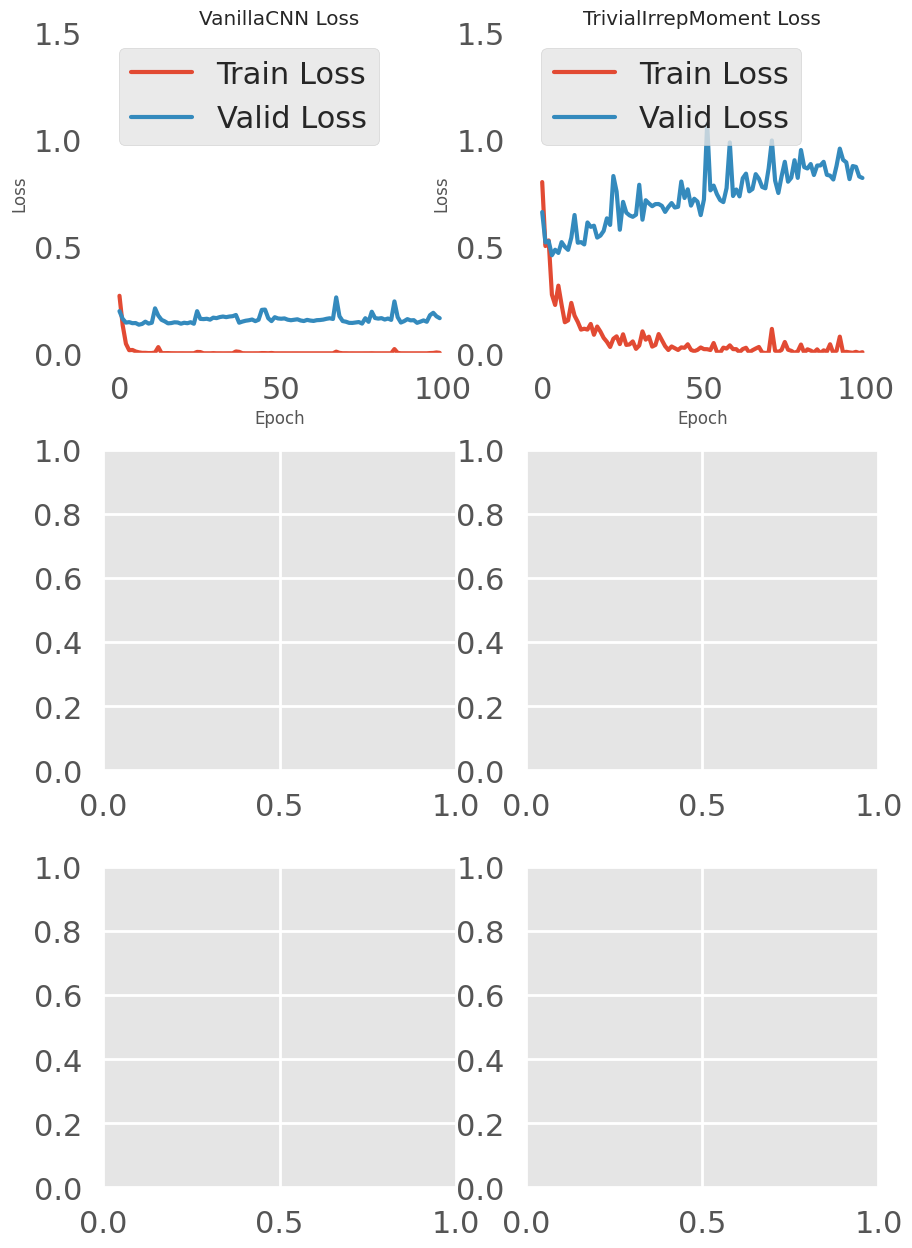

In [66]:
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (10, 15))
fig.subplots_adjust(hspace = 0.3)

for i, model in enumerate(models):
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(models[model]['metrics']['train_losses'], label = 'Train Loss')
    ax.plot(models[model]['metrics']['valid_losses'], label = 'Valid Loss')
    ax.set_title(f"{model} Loss")
    ax.set_ylim(0, 1.5)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.patch.set_facecolor('white') 
    ax.legend(loc='upper left')

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"loss.png"))
plt.show()

### **AUC/Acc**

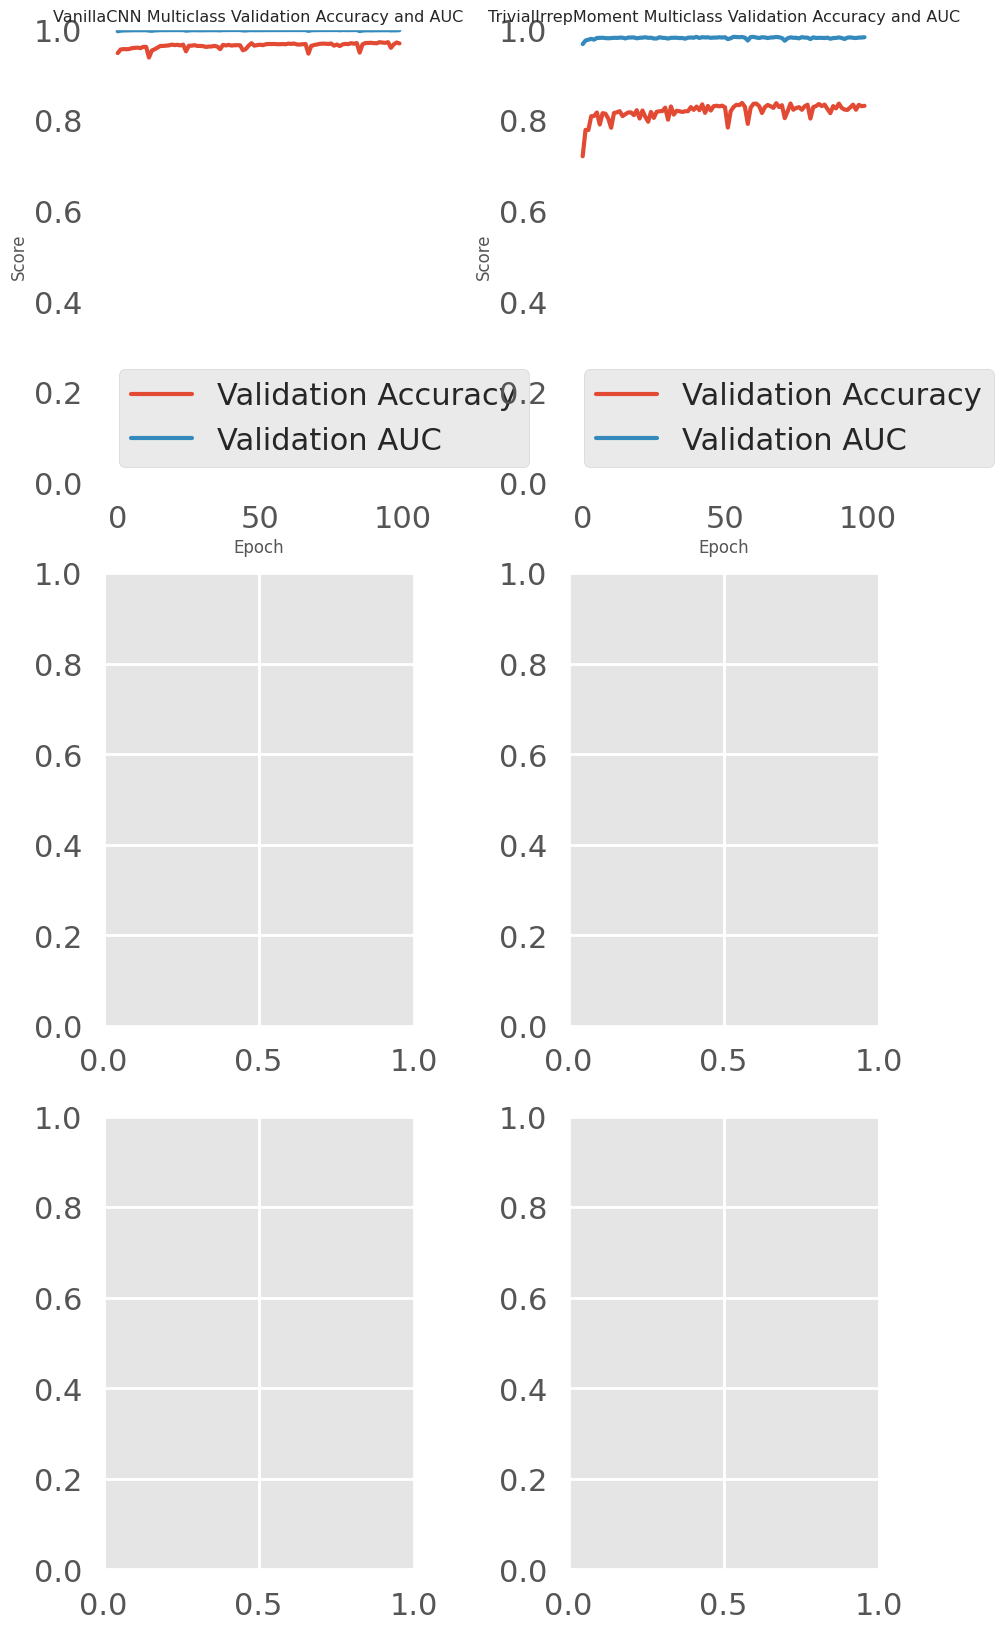

In [67]:
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (10, 20))
fig.subplots_adjust(hspace = 0.2, wspace = 0.5)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 8})

for i, model in enumerate(models):
    # Accuracy
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(models[model]['metrics']['valid_accuracies'], label = 'Validation Accuracy')

    # AUCROC
    ax.plot(models[model]['metrics']['valid_AUCROC'], label = 'Validation AUC')

    # other
    ax.set_title(f"{model} Multiclass Validation Accuracy and AUC")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.patch.set_facecolor('white') 
    ax.set_ylim(0, 1)

    ax.legend(loc='lower left')

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"acc_AUC_epochs.png"))
plt.show()

### **Timing**

In [68]:
times_table = pd.DataFrame(columns = ['Model', 'Mean Epoch Time'])

for model_name, model_dict in models.items():
    model = model_dict['model']
    times_table.loc[len(times_table)] = [model_name, np.mean(model_dict['metrics']['epoch_times'])]

times_table

,Model,Mean Epoch Time
0,VanillaCNN,9.810206
1,TrivialIrrepMoment,53.958995


### **Sample Confusion Matrix**

In [69]:
#model_names = ['TrivialMoment', 'TrivialIrrepMoment', 'TrivialECNN', 'TrivialIrrepECNN', 'RegularECNN', 'VanillaCNN']
model_names = ['TrivialIrrepMoment', 'VanillaCNN']
model_name = model_names[0]
model = models[model_name]['model']
model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_{model_name}_{data_flag}{run}.pt")), strict = False)
model = model.eval()

In [70]:
targets = []
predictions = []

with torch.no_grad():
    for i, sample_batch in enumerate(test_loader):
        sample_images = sample_batch[0].to(device)
        labels = sample_batch[1].to(device)

        prediction = model(sample_images)
        prediction = F.softmax(prediction, dim = 1)
        prediction = torch.argmax(prediction, dim = 1)

        targets.extend(labels.squeeze())
        predictions.extend(prediction)

    targets = torch.stack(targets)
    predictions = torch.stack(predictions)

cm = multiclass_confusion_matrix(targets, predictions, n_classes).cpu().numpy()

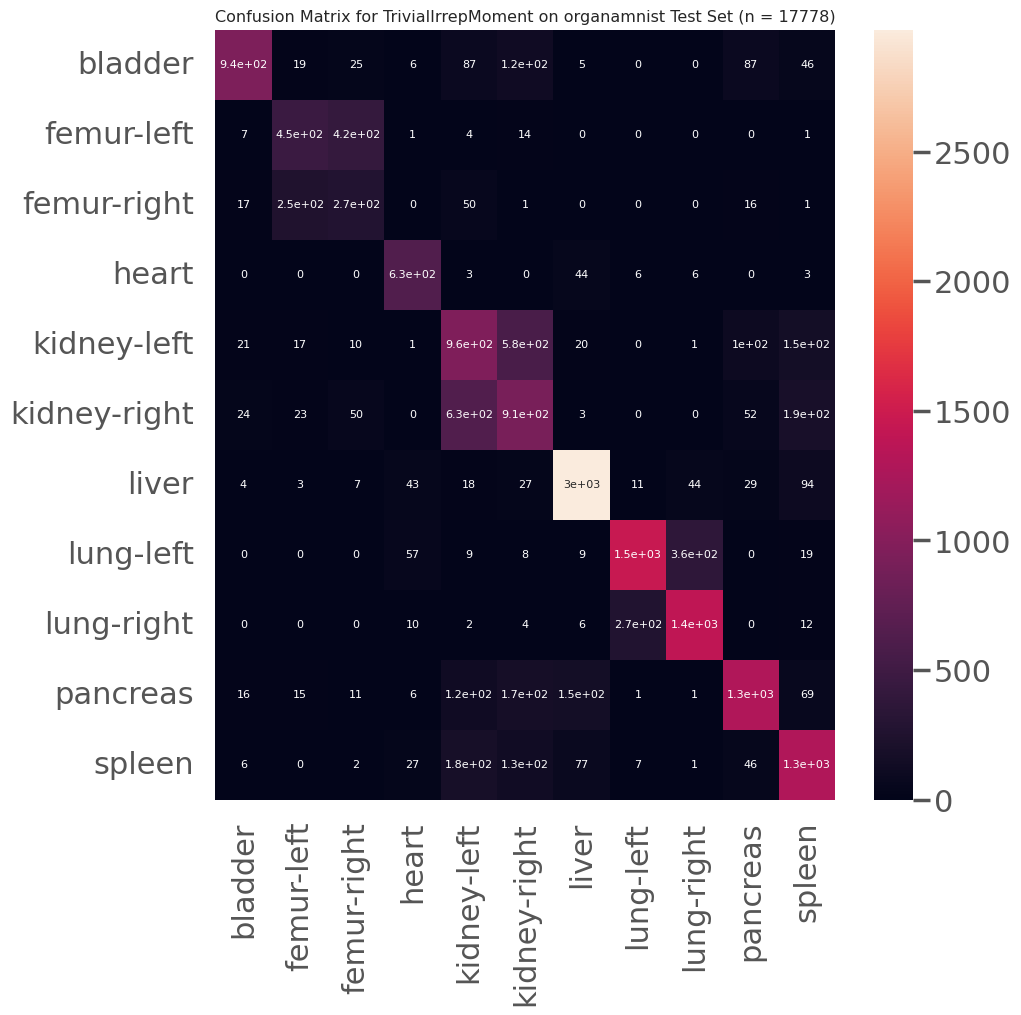

In [71]:
labels = info['label'].values()
plt.figure(figsize = (10, 10))
plt.title(f"Confusion Matrix for {model_name} on {data_flag} Test Set (n = {len(test_dataset)})")
sns.heatmap(cm, annot = True, xticklabels=labels, yticklabels=labels)

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

plt.savefig(os.path.join(fig_path, f"{model_name}_confusion_matrix.png"))
plt.show()

### **ROC**

In [72]:
targets = []
predictions = []

with torch.no_grad():
    for i, sample_batch in enumerate(test_loader):
        sample_images = sample_batch[0].to(device)
        labels = sample_batch[1].to(device)

        prediction = model(sample_images)
        prediction = F.softmax(prediction, dim = 1)

        targets.extend(labels.squeeze())
        predictions.extend(prediction)

    targets = torch.stack(targets)
    predictions = torch.stack(predictions)

    roc = ROC(task = 'multiclass', num_classes = n_classes)
    roc.update(predictions, targets)

fpr, tpr, thresholds = roc.compute()

In [73]:
plt.style.use('ggplot')

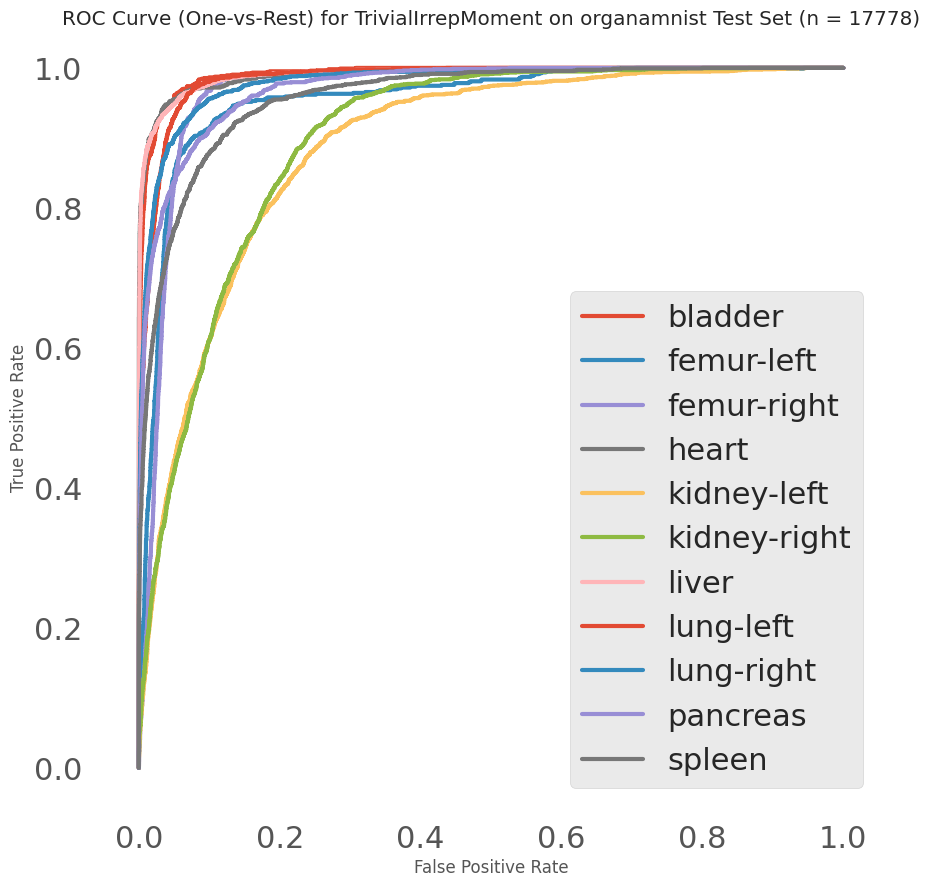

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(n_classes):
    ax.plot(fpr[i].cpu().numpy(), tpr[i].cpu().numpy(), label=f"{info['label'][str(i)]}")

ax.patch.set_facecolor('white')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.set_title(f"ROC Curve (One-vs-Rest) for {model_name} on {data_flag} Test Set (n = {len(test_dataset)})")

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

plt.savefig(os.path.join(fig_path, f"{model_name}_ROC.png"))
plt.show()

### **More Visualizations and Tables**

In [75]:
plt.style.use('ggplot')

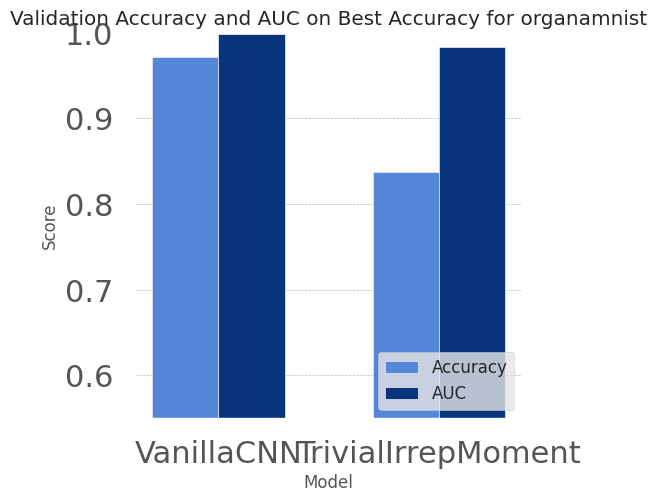

In [76]:
# plot of validation accuracy and AUC on best accuracy for each model
fig, ax = plt.subplots(figsize = (5, 5))
width = 0.3
xlabels = [name for name in models]
#x = np.arange(6)
x = np.arange(2)

ax.bar(x, [models[name]['metrics']['best_acc'] for name in models], width, label = 'Accuracy', color = '#5587d9')
ax.bar(x + width, [models[name]['metrics']['auc_on_best_acc'] for name in models], width, label = 'AUC', color = '#09357d')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(xlabels)
ax.legend(loc='lower right', prop={'size': 12})
ax.patch.set_facecolor('white')
ax.set_title(f"Validation Accuracy and AUC on Best Accuracy for {data_flag}")
ax.set_ylim(0.55, 1)
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"valid_best_acc_AUC.png"))
plt.show()

In [77]:
# test metrics table for each model

test_metrics_table = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC', '# Params', 'Channels', 'N Layers'])
test_metrics_table = test_metrics_table.astype({'Accuracy': 'float', 'AUC': 'float', '# Params': 'int', 'Channels': 'int', 'N Layers': 'int'})

for model_name, model_dict in models.items():
    model = model_dict['model']
    test_metrics_table = pd.concat([test_metrics_table, pd.DataFrame([[model_name, 0.0, 0.0, model_dict['num_params'], model_dict['n_channels'], model_dict['n_layers']]], columns=test_metrics_table.columns)], ignore_index=True)

acc = MulticlassAccuracy(num_classes=n_classes, device=device)
auc = MulticlassAUROC(num_classes=n_classes, device=device)

with torch.no_grad():
    for model_name in models.keys():
        test_model = models[model_name]['model'].eval()
        test_model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_{model_name}_{data_flag}{run}.pt")), strict=False)
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device).squeeze()
            predictions = test_model(images)
            acc.update(predictions, labels)
            auc.update(predictions, labels)

        model_acc = acc.compute().detach().item()
        model_auc = auc.compute().detach().item()

        test_metrics_table.loc[test_metrics_table['Model'] == model_name, 'Accuracy'] = round(model_acc, 3)
        test_metrics_table.loc[test_metrics_table['Model'] == model_name, 'AUC'] = round(model_auc, 3)

        acc.reset()
        auc.reset()

test_metrics_table.index = ['' for _ in range(len(test_metrics_table))]
test_metrics_table


,Model,Accuracy,AUC,# Params,Channels,N Layers
,VanillaCNN,0.881,0.984,1575627,32,5
,TrivialIrrepMoment,0.708,0.953,1569111,59,5


In [78]:
frame_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")

if not os.path.exists(frame_path):
    os.makedirs(frame_path)
md_frame = test_metrics_table.to_markdown()

with open(os.path.join(frame_path, f"run{run}_test_metrics.md"), "w") as f:
    f.write(md_frame)

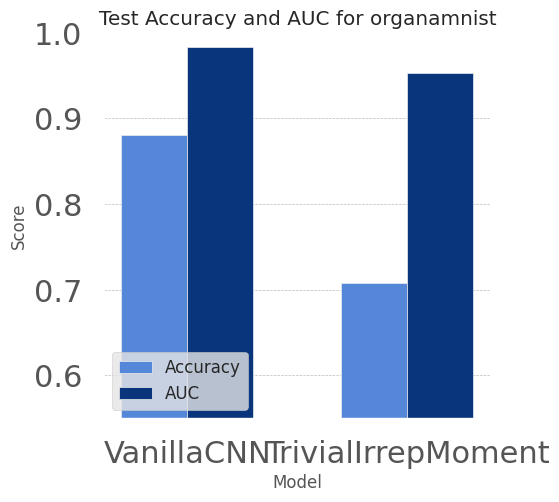

In [79]:
# plot of test accuracy and AUC for each model

fig, ax = plt.subplots(figsize = (5, 5))
width = 0.3
xlabels = [name for name in models]
#x = np.arange(6)
x = np.arange(2)

ax.bar(x, test_metrics_table['Accuracy'], width, label = 'Accuracy', color = '#5587d9')
ax.bar(x + width, test_metrics_table['AUC'], width, label = 'AUC', color = '#09357d')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(xlabels)
ax.legend(loc='lower left', prop={'size': 12})
ax.patch.set_facecolor('white')
ax.set_title(f"Test Accuracy and AUC for {data_flag}")
ax.set_ylim(0.55, 1)
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.show()

# save the plot
fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig.savefig(os.path.join(fig_path, f"test_acc_AUC.png"))

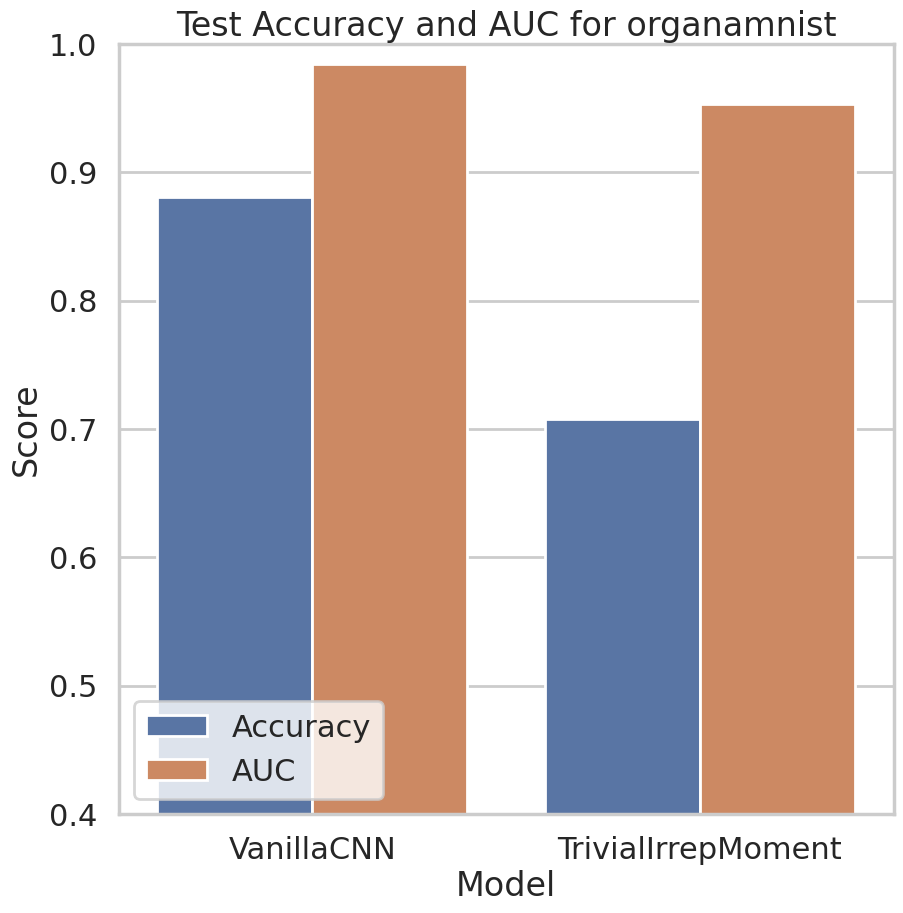

In [80]:
test_metrics_table = test_metrics_table[['Model', 'Accuracy', 'AUC']]
melted_test_metrics_table = test_metrics_table.melt(id_vars = 'Model', var_name = 'Metric', value_name = 'Score')

sns.set_theme(style = 'whitegrid')
sns.set_context('poster')
plt.figure(figsize = (10, 10))
sns.barplot(data = melted_test_metrics_table, x = 'Model', y = 'Score', hue = 'Metric')
plt.title(f"Test Accuracy and AUC for {data_flag}")
plt.ylim(0.40, 1)
plt.legend(loc = 'lower left')


In [81]:
# table of best validation accuracy, AUC on best accuracy, number of parameters, and number of layers for each model

valid_metrics_table = pd.DataFrame(columns = ['Model', 'Best Accuracy', 'AUC on Best Acc', '# Parameters', '# Layers'])

for model_name, model_dict in models.items():
    model = model_dict['model']
    valid_metrics_table.loc[len(valid_metrics_table)] = [model_name, round(model_dict['metrics']['best_acc'], 3), round(model_dict['metrics']['auc_on_best_acc'], 3), model_dict['num_params'], model_dict['n_layers']]

valid_metrics_table.index = ['' for _ in range(len(valid_metrics_table))]
valid_metrics_table

,Model,Best Accuracy,AUC on Best Acc,# Parameters,# Layers
,VanillaCNN,0.972,0.998,1575627,5
,TrivialIrrepMoment,0.838,0.983,1569111,5


In [82]:
# save the frame
frame_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}")

if not os.path.exists(frame_path):
    os.makedirs(frame_path)
md_frame = valid_metrics_table.to_markdown()

with open(os.path.join(frame_path, f"run{run}_valid_metrics.md"), "w") as f:
    f.write(md_frame)

### **Feature Map Testing Stuff**

In [83]:
model_name = 'TrivialIrrepMoment'
model = models[model_name]['model']
model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_{model_name}_{data_flag}{run}.pt")), strict = False)
model.to(device)
model.eval()

intermediate_output = {}
def make_hook(key):
    def hook(module, input, output):
        intermediate_output[key] = output.detach().cpu().numpy()
    return hook

hooks = []
for name, module in model.named_modules():
    if model_name == 'TrivialIrrepMoment':
        if type(module) == mk.ScalarVectorToScalarVector:
            hooks.append(module.register_forward_hook(make_hook(name)))
    if model_name == 'TrivialMoment':
        if type(module) == mk.ScalarToScalar:
            hooks.append(module.register_forward_hook(make_hook(name)))
    if model_name == 'VanillaCNN':
        if type(module) == tnn.Conv2d:
            hooks.append(module.register_forward_hook(make_hook(name)))

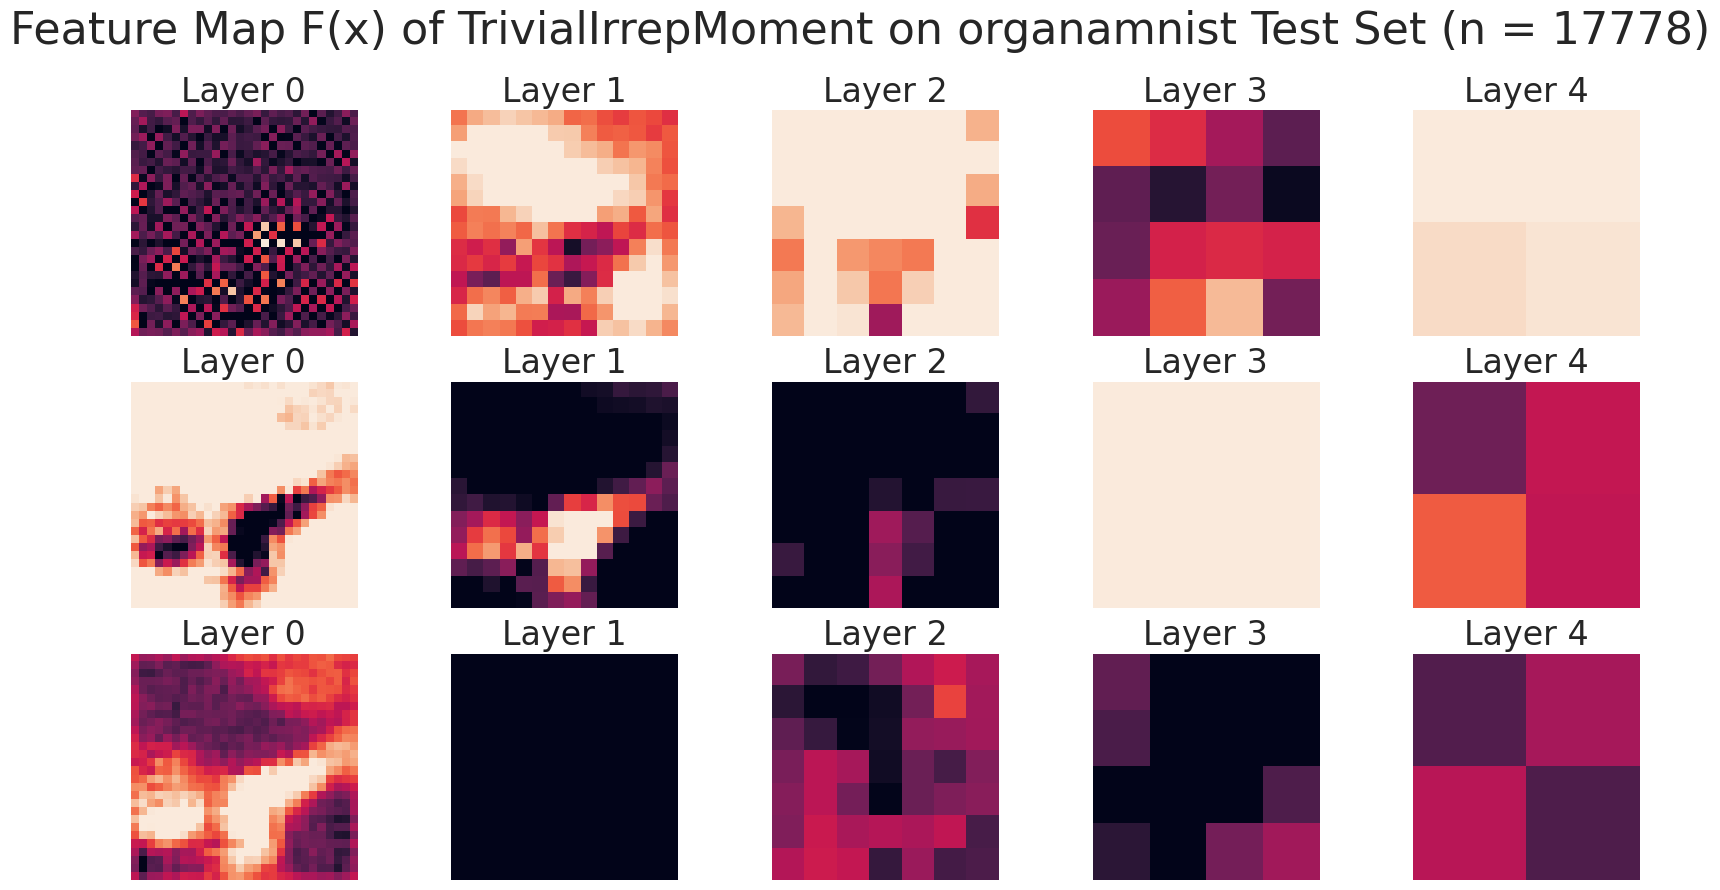

In [84]:
sample_batch = next(iter(test_loader))
sample_images = sample_batch[0].to(device)
image0 = sample_images[0].to(device)
image0 = image0.unsqueeze(0)

model(image0)
copy_intermediate_output0 = intermediate_output.copy()

n_layers = len(intermediate_output)
fig, axes = plt.subplots(3, n_layers, figsize = (20, 10))
fig.suptitle(f"Feature Map F(x) of {model_name} on {data_flag} Test Set (n = {len(test_dataset)})", fontsize = 32)
for ax in axes.flatten():
    ax.axis('off')
for i, (name, output) in enumerate(intermediate_output.items()):
    for j in range(3): # first 3 channels as an example
        img = output[0, j]
        axes[j, i].imshow(img, vmin=-1, vmax=1)
        axes[j, i].set_title(f"Layer {i}")

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(os.path.join(fig_path, f"{model_name}_feature_maps.png"))

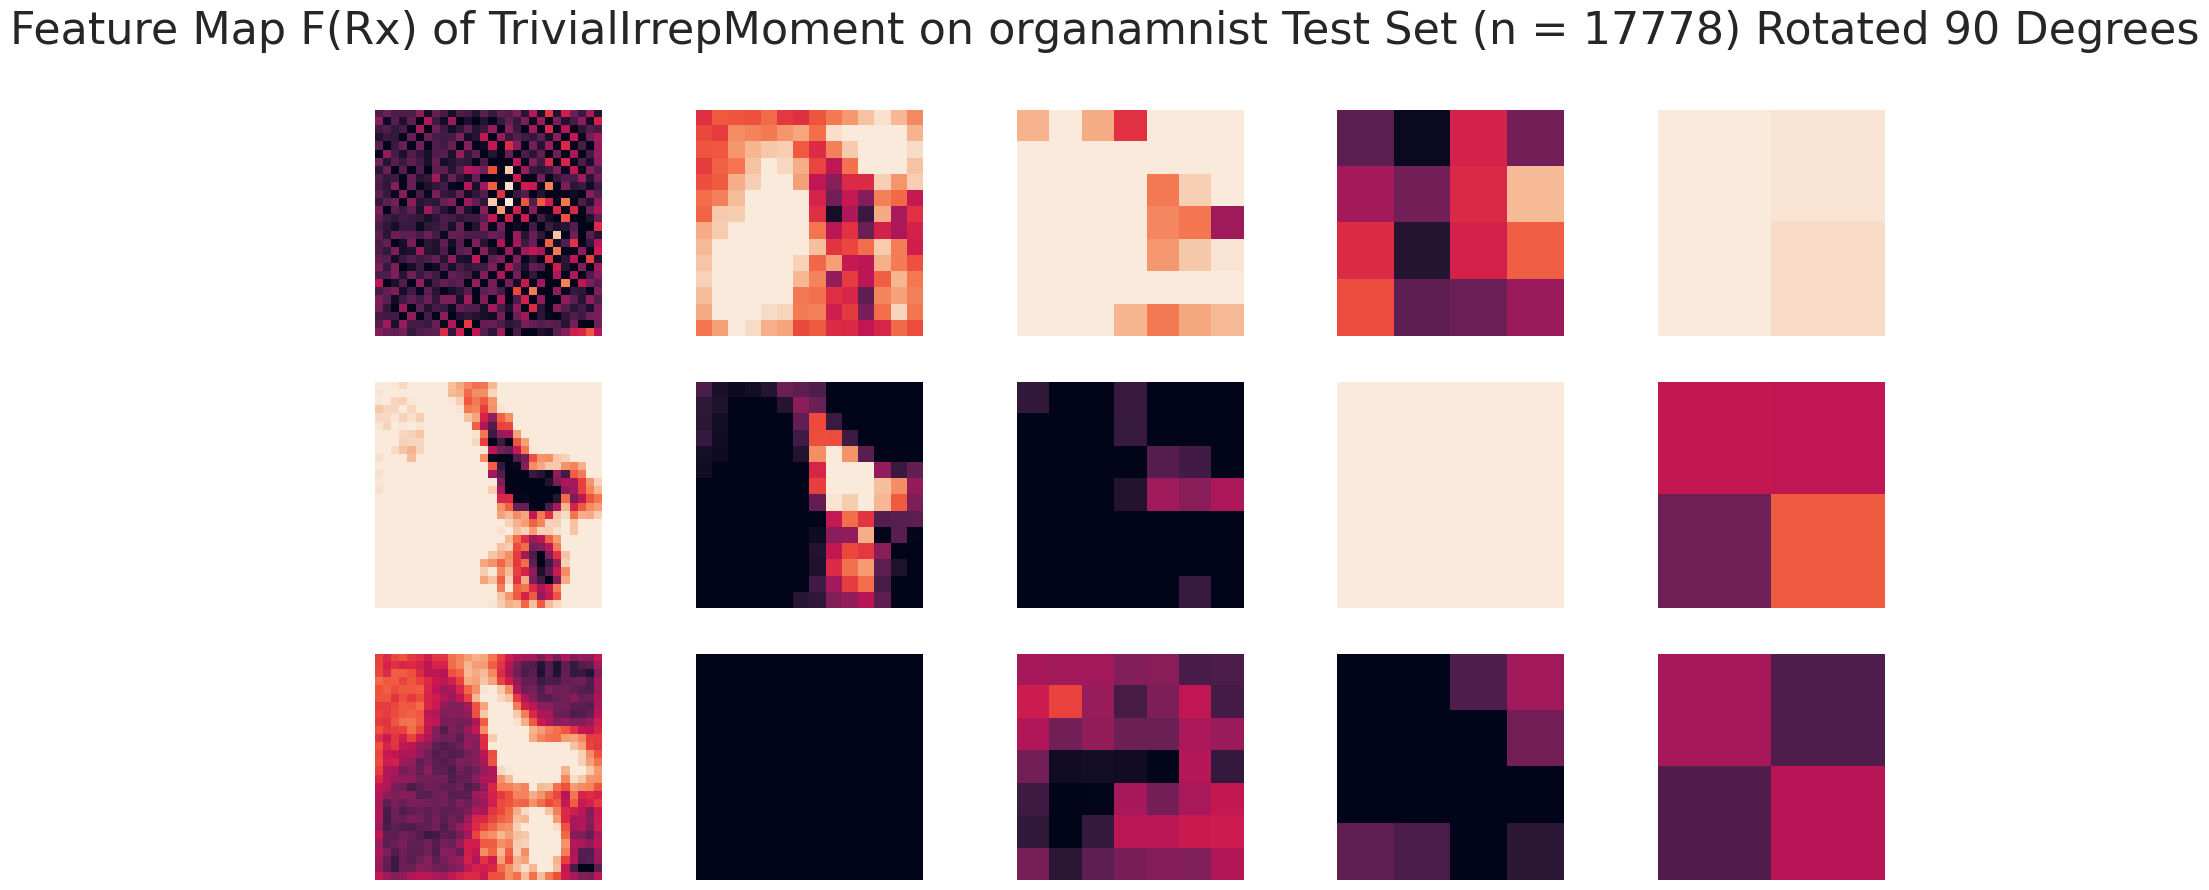

In [85]:
image90 = rotate(image0, 90)

intermediate_output = {}
model(image90)

#save for later
copy_intermediate_output90 = intermediate_output.copy()

n_layers = len(intermediate_output)
fig, axes = plt.subplots(3, n_layers, figsize = (20, 10))
fig.suptitle(f"Feature Map F(Rx) of {model_name} on {data_flag} Test Set (n = {len(test_dataset)}) Rotated 90 Degrees", fontsize = 32)
for ax in axes.flatten():
    ax.axis('off')

for i, (name, output) in enumerate(intermediate_output.items()):
    for j in range(3): # first 3 channels as an example
        img = output[0, j]
        axes[j, i].imshow(img, vmin=-1, vmax=1)

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(os.path.join(fig_path, f"{model_name}_feature_maps_rotated.png"))

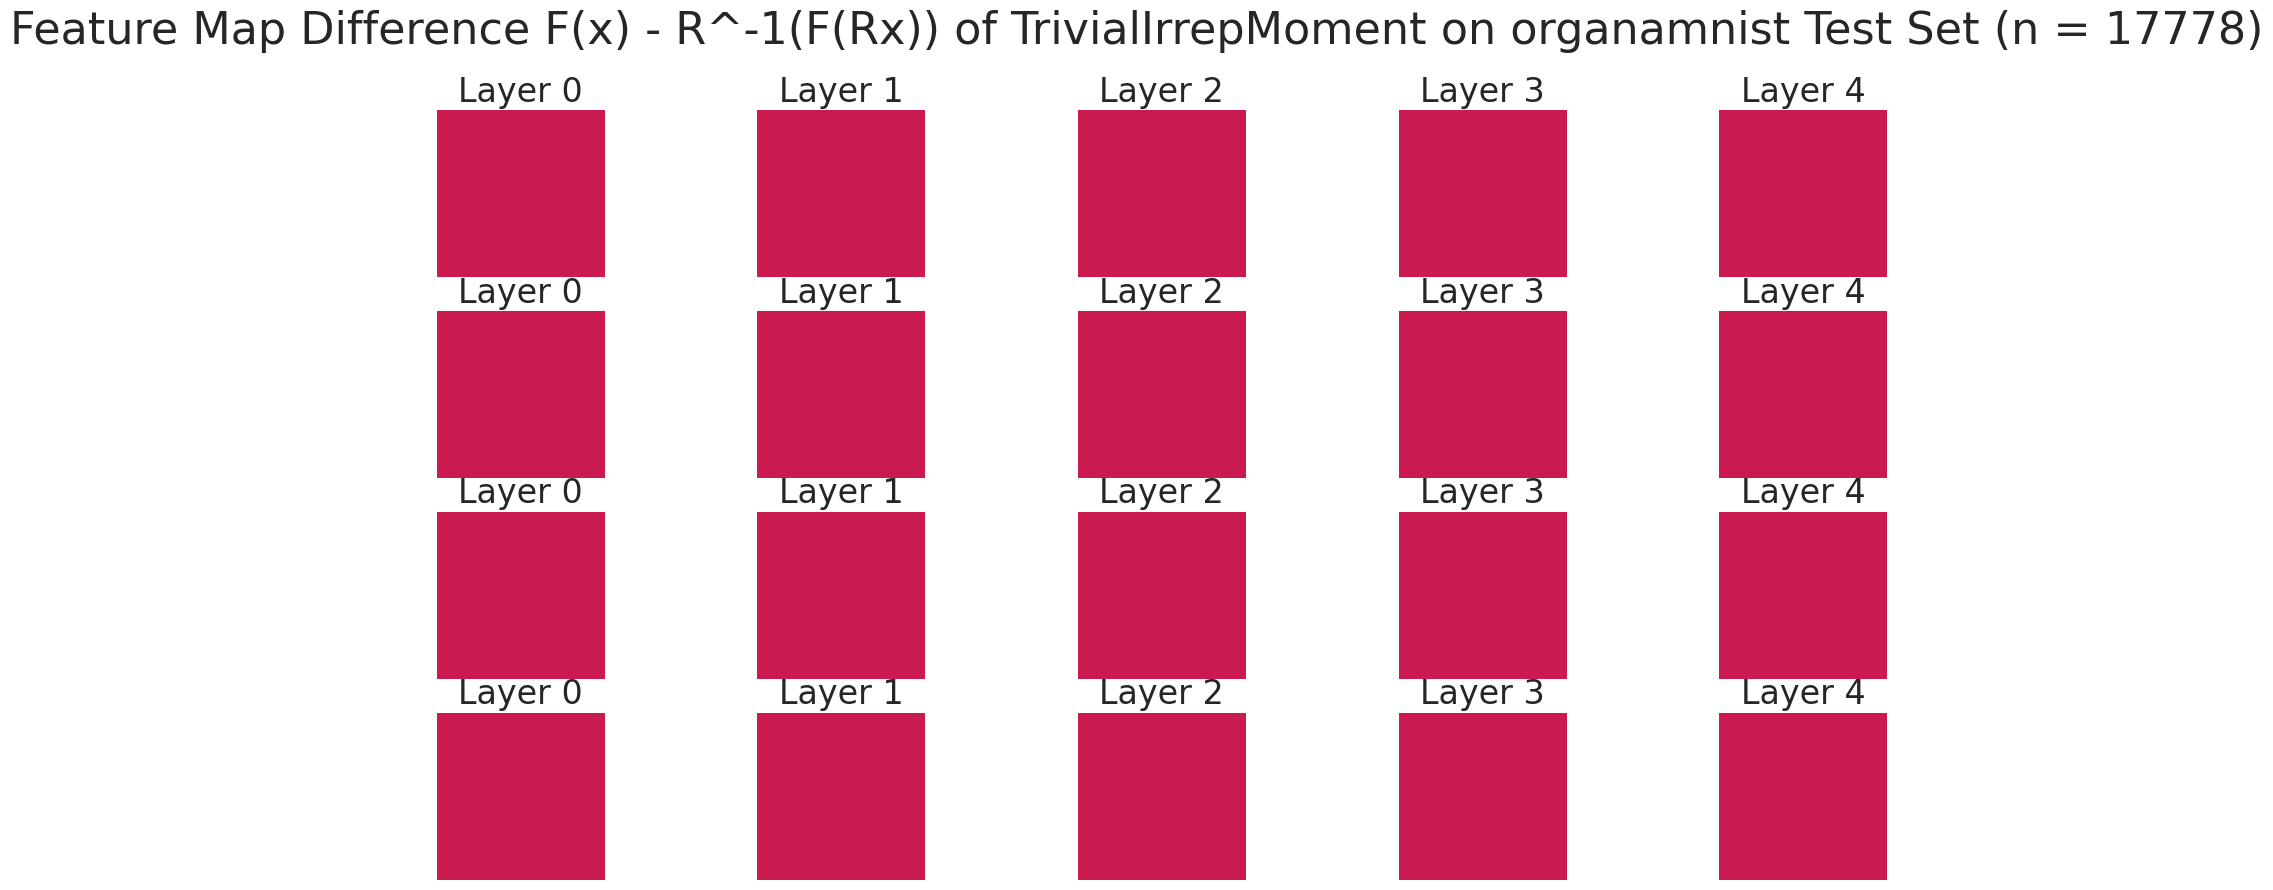

In [86]:
act_layer_names0 = [key for key in copy_intermediate_output0.keys()]
act_layer_name90 = [key for key in copy_intermediate_output90.keys()]

act_layer_output0 = [value for value in copy_intermediate_output0.values()]
act_layer_output90 = [np.rot90(value, k = -1, axes = (2, 3)) for value in copy_intermediate_output90.values()]
     
# calculate the difference between the two: f(t(x)) - t(f(x))
diff = [np.abs(act_layer_output0[i] - act_layer_output90[i]) for i in range(len(act_layer_output0))]

n_layers = len(act_layer_output0)
fig, axes = plt.subplots(4, n_layers, figsize = (20, 10))
fig.suptitle(f"Feature Map Difference F(x) - R^-1(F(Rx)) of {model_name} on {data_flag} Test Set (n = {len(test_dataset)})", fontsize = 32)
for ax in axes.flatten():
    ax.axis('off')

for i, output in enumerate(diff):
    for j in range(4): # first 3 channels as an example
        img = output[0, j]
        axes[j, i].imshow(img, vmin = -1, vmax = 1)
        axes[j, i].set_title(f"Layer {i}")

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(os.path.join(fig_path, f"{model_name}_feature_maps_diff.png"))

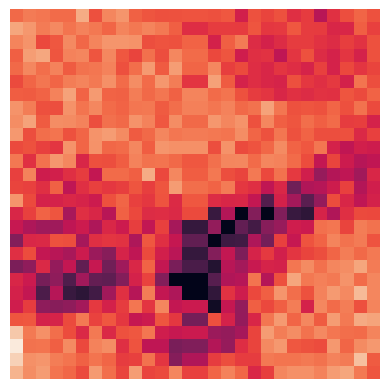

In [87]:
#plot original image as rgb
plt.imshow(sample_images[0].permute(1,2,0).cpu().numpy())
plt.axis('off')
#print(info['label'][str(labels[0].tolist()[0])])

fig_path = os.path.join(os.getcwd(), "benchmark", "figures", f"{data_flag}", f"run{run}", f"{model_name}")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
plt.savefig(os.path.join(fig_path, f"{model_name}_original_image.png"))

### **Rotational Equivariance on Cropped Data**

In [90]:
data_flag = 'octmnist'
run = 1

download = False
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
class CircleCrop(object):
    def __init__(self, h, w, center=None, radius=None):
        self.h = h
        self.w = w
        self.center = center
        self.radius = radius

    def __call__(self, img):
        if self.center is None:
            self.center = (self.h // 2, self.w // 2)
        if self.radius is None:
            self.radius = min(self.h, self.w) // 2

        y, x = np.ogrid[:self.h, :self.w]
        dist_from_center = np.sqrt((x - self.center[0]) ** 2 + (y - self.center[1]) ** 2)
        mask = dist_from_center <= self.radius
        img[:, ~mask] = 0
        return img
    
    def __repr__(self):
        return self.__class__.__name__ + f"(h={self.h}, w={self.w}, center={self.center}, radius={self.radius})"

# transforms to convert from image to normalized tensor (or more if augmentation, but not for testing purposes)
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    CircleCrop(28, 28, radius = 14, center = (13.5, 13.5)),
    transforms.Normalize(mean = [0.5], std = [0.5]),
])

# separate transforms for test
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    CircleCrop(28, 28, radius = 14, center = (13.5, 13.5)),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

train_dataset = DataClass(split = "train", transform = train_transforms, download = download)
valid_dataset = DataClass(split = "val", transform = test_transforms, download = download)
test_dataset = DataClass(split = "test", transform = test_transforms, download = download)

train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = data.DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [92]:
model_name = 'TrivialMoment'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {
    'VanillaCNN' : {'model' : VanillaCNN(n_channels, 32, n_classes, 3, 1, num_layers)},
    'TrivialECNN' : {'model' : TrivialECNN(n_channels, 67, n_classes, 3, 1, num_layers)},
    'TrivialIrrepECNN' : {'model' : TrivialIrrepECNN(n_channels, 62, n_classes, 3, 1, num_layers)},
    'RegularECNN' : {'model' : RegularECNN(n_channels, 29, n_classes, 3, 1, num_layers)},
    'TrivialMoment' : {'model' : TrivialMoment(n_channels, 55, n_classes, 3, 1, num_layers)},
    'TrivialIrrepMoment' : {'model' : TrivialIrrepMoment(n_channels, 59, n_classes, 3, 1, num_layers)},
}

In [93]:
model = models[model_name]['model']
model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_{model_name}_{data_flag}{run}.pt")), strict = False)

reference_model = models['VanillaCNN']['model']
reference_model.load_state_dict(torch.load(os.path.join(path, 'benchmark', 'results', f"{data_flag}", f"run{run}", f"best_acc_VanillaCNN_{data_flag}{run}.pt")), strict = False)

<All keys matched successfully>

In [101]:
model.eval()
reference_model.eval()
with torch.no_grad():
    nangles = 36
    angles = np.arange(nangles)/nangles*360
    accuracysave = []
    accuracysave_ = []
    aucsave_ = []
    auc1save_ = []

    for angle in angles:
        ltrue = []
        ltrue_ = []
        lpred = []
        lpred_ = []
        for i, sample_batch in enumerate(test_loader):
            sample_images = sample_batch[0].to(device)
            labels = sample_batch[1].to(device).squeeze()
            x_rot = rotate(sample_images, angle)
            prediction = model(x_rot)
            prediction_ = reference_model(x_rot)
            prediction = F.softmax(prediction, dim = 1)
            prediction = torch.argmax(prediction, dim = 1)
            prediction_ = F.softmax(prediction_, dim = 1)
            prediction_ = torch.argmax(prediction_, dim = 1)
            ltrue.extend(labels.cpu().numpy())
            ltrue_.extend(labels.cpu().numpy())
            lpred.extend(prediction.cpu().numpy())
            lpred_.extend(prediction_.cpu().numpy())

        print(f"accuracy: {np.mean(np.array(ltrue) == np.array(lpred))}")
        print(f"accuracy_: {np.mean(np.array(ltrue_) == np.array(lpred_))}")
        accuracy = np.mean(np.array(ltrue) == np.array(lpred))
        accuracy_ = np.mean(np.array(ltrue_) == np.array(lpred_))
        accuracysave.append(accuracy)
        accuracysave_.append(accuracy_)

accuracy: 0.648
accuracy_: 0.674
accuracy: 0.319
accuracy_: 0.453
accuracy: 0.324
accuracy_: 0.335
accuracy: 0.306
accuracy_: 0.353
accuracy: 0.264
accuracy_: 0.29
accuracy: 0.277
accuracy_: 0.3
accuracy: 0.327
accuracy_: 0.308
accuracy: 0.328
accuracy_: 0.29
accuracy: 0.333
accuracy_: 0.268
accuracy: 0.648
accuracy_: 0.252
accuracy: 0.319
accuracy_: 0.237
accuracy: 0.324
accuracy_: 0.257
accuracy: 0.306
accuracy_: 0.253
accuracy: 0.264
accuracy_: 0.263
accuracy: 0.277
accuracy_: 0.268
accuracy: 0.327
accuracy_: 0.298
accuracy: 0.328
accuracy_: 0.345
accuracy: 0.333
accuracy_: 0.33
accuracy: 0.648
accuracy_: 0.415
accuracy: 0.319
accuracy_: 0.322
accuracy: 0.324
accuracy_: 0.306
accuracy: 0.306
accuracy_: 0.304
accuracy: 0.264
accuracy_: 0.267
accuracy: 0.277
accuracy_: 0.282
accuracy: 0.327
accuracy_: 0.286
accuracy: 0.328
accuracy_: 0.282
accuracy: 0.333
accuracy_: 0.294
accuracy: 0.648
accuracy_: 0.272
accuracy: 0.319
accuracy_: 0.262
accuracy: 0.324
accuracy_: 0.267
accuracy: 0.306

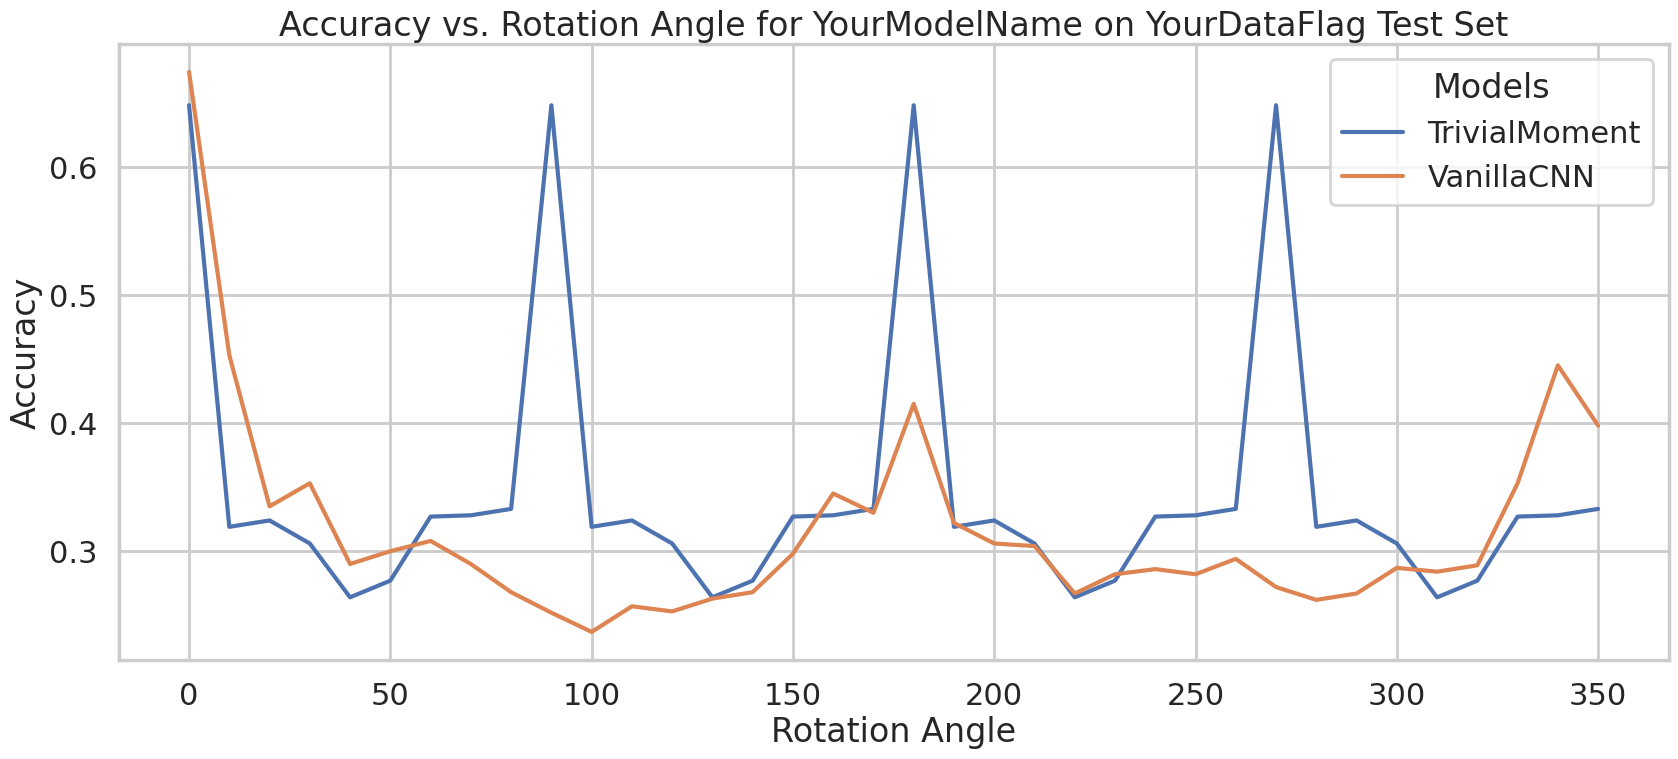

In [105]:
# Set the theme and context
sns.set_theme(style='whitegrid', context='poster')

# Create the plot
plt.figure(figsize=(20, 8))
sns.lineplot(x=angles, y=accuracysave, label='TrivialMoment') #marker='o')
sns.lineplot(x=angles, y=accuracysave_, label='VanillaCNN')# marker='s')

# Customize the axes and title
plt.xlabel('Rotation Angle')
plt.ylabel('Accuracy')
plt.title(f"Accuracy vs. Rotation Angle for {model_name} on {data_flag} Test Set")

# Display the legend
plt.legend(title='Models')

# Show the plot
plt.show()
